In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle

from scipy.stats import truncnorm, powerlaw, beta, zipf, norm
from scipy.integrate import quad

%matplotlib inline

#%matplotlib notebook

## For this fake catalog, will need:
* Reasonable sets of stellar properties (Teff, logg, [Fe/H]) --- draw from Kepler target stars
* Distribution of multiplicities --- Zipfian, with parameters from our paper.
* Distribution of planet periods --- log-uniform. Check for Hill stability with each planet draw.
* Distribution of planet radii --- double-sided power law. Preference for size ordering could be enforced in the next iteration with David's mass budget idea.

## The "true" fake catalog will follow the above rules. The "false" fake catalog will not (or...(later down the line) use the real KOIs as the "fake" catalog?)

### "Wrong" fake catalog options:
* draw planet periods from uniform distribution
* draw planet radii from log-uniform distribution

### Necessary transforms: log-uniform, Zipfian, DSPL (among others).

In [2]:
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

def transform_normal(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)

def transform_beta(x,a,b):
    return beta.ppf(x,a,b)

def transform_truncated_normal(x,mu,sigma,a=0.,b=1.):
    ar, br = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.ppf(x,ar,br,loc=mu,scale=sigma)

def transform_powerlaw(x,a):
    return powerlaw.ppf(x,a+1)

def transform_zipfian(x,beta):
    #return powerlaw.ppf(x,-1-beta)
    return zipf.ppf(x,beta+1)

In [3]:
def smallplanet_prob(a_small, a_big, logRmin, logRcrit, logRmax):
    
    denom = -logRmin*(1.0+a_big) + logRcrit*(a_big-a_small) + logRmax*(1.0+a_small)
    
    sp_prob = ( (logRcrit-logRmin)*(1.0+a_big) )/denom
 
    return sp_prob


def random_smallplanet(a_small, logRmin, logRcrit):
    z = np.random.uniform()
    
    random_smallR = z*(logRcrit - logRmin)**(1.0+a_small)
    random_smallR = logRmin + random_smallR**( 1.0/(1.0+a_small) )

    return random_smallR


def random_bigplanet(a_big, logRcrit, logRmax):
    z = np.random.uniform()
    
    random_bigR = (1.0-z)**( 1.0/(1.0+a_big) )
    random_bigR = logRmax - random_bigR*(logRmax - logRcrit)
    
    return random_bigR



def random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax):
    """
    return a random planet radius from a double-sided power law distribution
    """
    p_threshold = smallplanet_prob(a_small,a_big,logRmin,logRcrit,logRmax)

    if x < p_threshold:
        return random_smallplanet(a_small, logRmin, logRcrit)
    else:
        return random_bigplanet(a_big, logRcrit, logRmax)

#### Test log-uniform distribution.

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


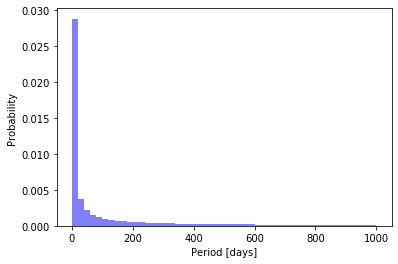

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


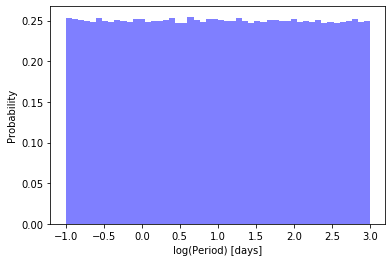

1.0


In [4]:
Pmin = 0.1 #days
Pmax = 1000. #days

random_periods = np.zeros((1000000))

for i in range(len(random_periods)):
    x = np.random.uniform()
    random_periods[i] = transform_loguniform(x,Pmin,Pmax)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_periods,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("Period [days]")
plt.ylabel("Probability")
plt.show()

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(np.log10(random_periods),normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(Period) [days]")
plt.ylabel("Probability")
plt.show()

#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

#### Test Zipfian distribution.

In [5]:
def zipf_cdf(beta_zipf,m_max):
    
    pdf = np.zeros(m_max)
    for i in range(1,m_max+1):
        pdf[i-1] = i**(-beta_zipf-1)
        
    norm = np.sum(pdf)
    
    pdf = pdf/norm
    
    cdf = np.zeros(m_max)
    
    cdf[0] = pdf[0]
    
    for i in range(2,m_max+1):
        cdf[i-1] = cdf[i-2] + pdf[i-1]
        
    return cdf

def transform_zipf(x, beta_zipf, m_max):
    cdf = zipf_cdf(beta_zipf, m_max)
    for i in range(0,m_max):
        if (x < cdf[i]):
            return i+1

10526


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


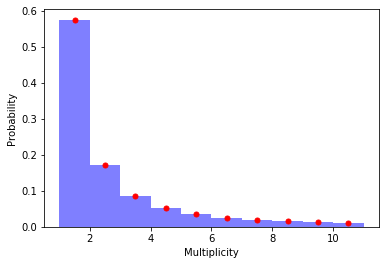

1.0


In [6]:
beta = 0.74

random_mults = np.zeros((1000000))

for i in range(len(random_mults)):
    x = np.random.uniform()
    random_mults[i] = transform_zipf(x,beta_zipf=beta,m_max=10)

print(len(random_mults[random_mults==10]))

xs = np.arange(1,11,1)
fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_mults,normed=True,range=(1,11),bins=10,color='b',alpha=0.5)
plt.plot(xs+0.5, (xs**(-1-beta))*np.max(n),'r.',ms=10)
plt.xlabel("Multiplicity")
plt.ylabel("Probability")
plt.show()


#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

In [7]:
print(np.unique(random_mults))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


#### Test DSPL transform. 
Choose some radius distribution parameters and draw a bunch of random planet radii to make sure the distribution looks right.


In [8]:
logRmin = np.log(0.5) #R_earth
logRmax = np.log(32)  #R_earth
logRcrit = np.log(2.5) #R_earth
a_small = 0.3
a_big = 4.9


random_radii = np.zeros((1000000))

for i in range(len(random_radii)):
    x = np.random.uniform()
    random_radii[i] = random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax)


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


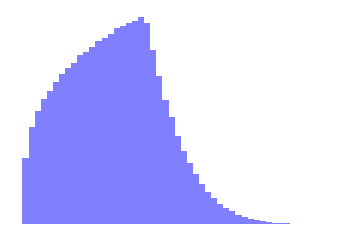

In [9]:
#small_xs = np.linspace(logRmin,logRcrit,100)
#small_ys = -0.5*(small_xs - logRmin)**(-1*a_small) + 1.02

#big_xs = (np.linspace(logRcrit+1,logRmax,100))
#big_ys = 0.6*(big_xs - logRcrit)**(-1*a_big)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_radii,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(R_p) [R_earth]")
plt.ylabel("Probability")
#plt.axvline(logRcrit,color='r',lw=2)
plt.axis("off")
plt.show()
#plt.savefig("./DSPL.pdf",fmt="pdf")

## Check for Hill stability

In [10]:
def mass_forecast(radius):
    """
    from Jingjing's paper
    """
    
    c1 = 0.003460532109506489
    c2 = -0.09252481979252211
    c3 = 1.2489241453022766
    c4 = -2.844669555228572
    
    s1 = 0.279
    s2 = 0.589
    s3 = -0.044
    s4 = 0.881
    
    t1 = 0.3096301674258988
    t2 = 2.1191926778748793
    t3 = 4.425506703276593
    t4 = 0.0
    
    logR = np.log10(radius)
    
    if logR < t1:
        logM = ( logR - c1 )/s1
    elif logR < t2:
        logM = ( logR - c2 )/s2
    elif logR < t3:
        logM = ( logR - c3 )/s3
    else:
        logM = ( logR - c4 )/s4
        
    return 10.**logM
 

In [11]:
def delta_Hill(Mstar,radius1,radius2,period1,period2):
    
    mass1 = mass_forecast(radius1)
    mass2 = mass_forecast(radius2)
    
    mass_star = Mstar*332978.9015405224 #convert solar masses to Earth masses

    ratio = 2.8844991406148166/( (mass1+mass2)/mass_star )**(1./3.)
    
    
    periodx_inner = (np.min((period1,period2)))**(2./3.)
    periodx_outer = (np.max((period1,period2)))**(2./3.)
    
    dH = ratio*( (periodx_outer-periodx_inner)/(periodx_outer+periodx_inner) )
    
    return dH

In [12]:
def hill_stability(mstar,nplanets,radii,periods):
    
    if nplanets == 1: #only one planet---always stable
        return True
    
    elif nplanets == 2:
        if delta_Hill(mstar, radii[0], radii[1], periods[0], periods[1]) > 3.4641016151377544:
            return True
        
    else:
        #assume stable until proven otherwises
        
        #test 1: go through pairs, from eq 8 of 2014ApJ...790..146F
        
        for i in range(0,nplanets-1):
            if delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) <= 3.4641016151377544:
                return False
        
        #test 2: go through triples, from eq 9 of 2014ApJ...790..146F
        for i in range(0, nplanets-2):
            if (delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) + 
                delta_Hill(mstar, radii[i+1], radii[i+2], periods[i+1], periods[i+2])) <= 18.:
                return False
        
        return True

# Make fakes!

In [13]:
#columns: Teff, logg, [Fe/H], mass, radius
kepStellar = np.genfromtxt("../../../../kepStellar.csv",delimiter=',')
print(np.shape(kepStellar))

#remove nans
nonans = (np.isfinite(kepStellar[:,0]) & 
          np.isfinite(kepStellar[:,1]) & 
          np.isfinite(kepStellar[:,2]) & 
          np.isfinite(kepStellar[:,3]) & 
          np.isfinite(kepStellar[:,4]))
kepStellar = kepStellar[nonans]
print(np.shape(kepStellar))

#select only dwarfs
kepStellar = kepStellar[(kepStellar[:,1] > 3.) & (kepStellar[:,1] < 5.3)]
print(np.shape(kepStellar))

#select only FGK
kepStellar = kepStellar[(kepStellar[:,0] > 3200.) & (kepStellar[:,0] < 9600.)]
print(np.shape(kepStellar))

#metallicity cut? nah
#print(np.min(kepStellar[:,2]))
#print(np.max(kepStellar[:,2]))

#mass cut
kepStellar = kepStellar[(kepStellar[:,3] > 0.13) & (kepStellar[:,3] < 2.7)]
print(np.shape(kepStellar))

#radius cut
kepStellar = kepStellar[(kepStellar[:,4] > 0.14) & (kepStellar[:,4] < 7.4)]
print(np.shape(kepStellar))


(197097, 5)
(197096, 5)
(177906, 5)
(177209, 5)
(177141, 5)
(177047, 5)


In [14]:
def make_two_rad_pops(nsystems,
                     multmodel='zipf',
                     beta_zipf=0.74,m_max=10,
                     Pmodel='loguniform',Pmin=0.1,Pmax=1000.,
                     Rsmall=0.05,sigmaRsmall=0.005,Rbig=0.15,sigmaRbig=0.01):
    """
    Make "nsystems" fake planetary systems. For each planet, draw its radius
    from either a Gaussian centered at Rsmall [solRadii] with sigma=sigmaRsmall, or else
    from a Gaussian centered at Rbig with sigma=sigmaRbig, with probability 0.5.
    """
    systems = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    for i in range(nsystems):
        system = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        rando = np.random.uniform()
                
        
        while mult < 2:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(np.random.uniform(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        multiplicities[i] = mult

        stable = False
        
        while stable is False:
        
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            
            for j in range(0,mult):
                periods[j] = transform_loguniform(np.random.uniform(),Pmin,Pmax)

            #sort periods in increasing order
            periods = np.sort(periods)
            
            for j in range(0,mult):
                if rando <= 0.5:
                    radii[j] = transform_normal(np.random.uniform(),mu=Rsmall,sigma=sigmaRsmall) #solar radii!!!
                else:
                    radii[j] = transform_normal(np.random.uniform(),mu=Rbig,sigma=sigmaRbig)
               
            stable = hill_stability(random_star[3], mult, radii, periods)
            
        #once a stable system is found:
        [allradii.append(np.round_(r,2)) for r in radii]
        
        for j in range(0, mult):
            #planet = [random_star[0],random_star[1],random_star[2],radii[j]/random_star[4],periods[j]]
            planet = [radii[j]/random_star[4]]
            system.append(planet)
        
        systems.append(system)
            
    return systems,multiplicities,allradii
    

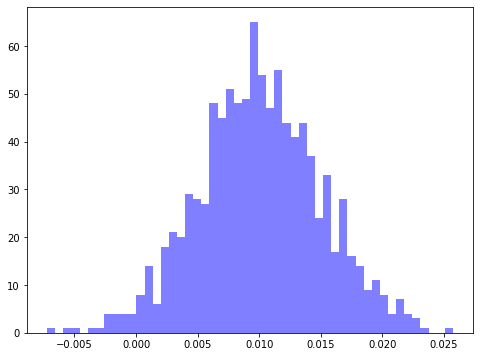

In [15]:
x = np.random.normal(loc=0.01,scale=0.005,size=1000)
fig = plt.figure(figsize=(8,6))
plt.hist(x,color='b',bins=50,alpha=0.5)
plt.show()

In [16]:
#overlapping Rp
#def grammaticalSystems(nsystems,
#                       multmodel='zipf',
#                       beta_zipf=0.74,m_max=10,
#                       Pmodel='loguniform',Pmin=0.25,Pmax=500.,
#                       R_A=0.01, sigmaR_A = 0.005, #solar radii
#                       R_B=0.05, sigmaR_B = 0.025,
#                       R_C=0.1, sigmaR_C = 0.025):

#deterministic Rp
#def grammaticalSystems(nsystems,
#                       multmodel='zipf',
#                       beta_zipf=0.74,m_max=3,
#                       Pmodel='loguniform',Pmin=0.25,Pmax=500.,
#                       R_A=0.01, sigmaR_A = 0.0005, #solar radii
#                       R_B=0.05, sigmaR_B = 0.0005,
#                       R_C=0.1, sigmaR_C = 0.0005):

#distinct Rp
def grammaticalSystems(nsystems,
                       multmodel='zipf',
                       beta_zipf=0.74,m_max=10,
                       Pmodel='loguniform',Pmin=0.25,Pmax=500.,
                       R_A=0.01, sigmaR_A = 0.0005, #solar radii
                       R_B=0.05, sigmaR_B = 0.0005,
                       R_C=0.1, sigmaR_C = 0.0005):

    """
    Make "nsystems" fake planetary systems. 
    
    Grammatical rules:
    
    1. "A" ~= "article"; "B" ~= "noun" or "adjective"; "C" ~= "verb". By analogy, "A" = "the"; a "B" sequence could 
    be something like, "Doggish doggish ratty cat" or "Horsey jellyfish" or "Giraffey capybara"; "C" could be "chased"
    or "ate" or "sang" (i.e. transitive or intransitive verb). Sentences could be e.g. "A B B C A B" = "The cowy flamingo
    ate the shrimp" or "A B B B B C" = "The birdy doggy catty fish called."
    2. A "B" sequence must be preceded by an "A".
    3. The subject of a "C" verb is an "A B ... B" sequence.
    
    
    2-planet system: A B only
    3-planet system: A B C only
    4-planet system: A B B C only
    5-planet system: A B B B C or 
                     A B C A B
    6-planet system: A B B B B C or 
                     A B C A B B or 
                     A B B C A B
    7-planet system: A B B B B B C or
                     A B C A B B B or
                     A B B B C A B
    etc for 8, 9, 10---only three possibilities per.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        system = []
        systemTrueClasses = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        while mult < 2:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(np.random.uniform(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        multiplicities[i] = mult

        stable = False
        
        while stable is False:
        
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(np.random.uniform(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(np.random.uniform(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            if mult <= 4:
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(np.random.uniform(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                #replace last radius with C
                radii[-1] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                truths[-1] = 2.
            elif mult==5:
                rando = np.random.randint(low=0,high=2,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(np.random.uniform(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                else:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A))
                    truths[3] = 0.
                    
            else:
                rando = np.random.randint(low=0,high=3,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(np.random.uniform(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                elif rando == 1:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A) )
                    truths[3] = 0.
                else:
                    #replace -3th radius with C
                    radii[-3] = np.abs(transform_normal(np.random.uniform(),mu=R_C,sigma=sigmaR_C))
                    truths[-3] = 2.
                    #replace -2th radius with A
                    radii[-2] = np.abs(transform_normal(np.random.uniform(),mu=R_A,sigma=sigmaR_A))
                    truths[-2] = 0.
                    
            stable = hill_stability(random_star[3], mult, radii, periods)
            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [17]:
def featureScale(trainingSet,n_features):
    """
    Scale each feature to have mean=0, stdev = 1
    """
    
    stacked = np.zeros((1,n_features))
    
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        for j in range(0,len(sys)):
            planet = np.array((sys[j]))
            stacked = np.vstack((stacked,planet))
            
    mu = np.mean(stacked,axis=0)
    sigma = np.std(stacked,axis=0)
    
    print(mu)
    print(sigma)
    scaledTrainingSet = []
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        newsys = []
        for j in range(0,len(sys)):
            planet = np.array(sys[j])
            planet = (planet - mu)/sigma
            newsys.append(list(planet))
            
        scaledTrainingSet.append(newsys)
    
    return scaledTrainingSet
            

In [18]:
test = np.zeros((1000,3))
print(np.shape(np.mean(test,axis=0)))

(3,)


In [19]:
experimentClass = "oneGrammar_distinctRp"
experimentName = "allFeatures_uniformP"
n_features = 5

sys, mult, rad, truths, trueClassesList, pers = grammaticalSystems(nsystems=10000,Pmodel="uniform")

np.save("./{0}/fake_grammaticalSystems_{1}_truths.npy".format(experimentClass,experimentName),truths)

scaled = featureScale(sys,n_features)

with open("./{0}/fake_grammaticalSystems_{1}.txt".format(experimentClass,experimentName), "wb") as picklefile:
    pickle.dump(scaled, picklefile)

with open("./{0}/fake_grammaticalSystems_{1}_truthsOrganized.txt".format(experimentClass,experimentName), "wb") as picklefile:
    pickle.dump(trueClassesList, picklefile)

print(type(sys))
print(type(mult))
print(type(rad))
print(type(truths))

print(len(sys))
print(np.shape(mult))
print(np.shape(rad))
print(np.shape(truths))

[ 5.08404003e-02  2.49413306e+02  5.75758949e+03  4.36119990e+00
 -1.76277945e-01]
[3.41752167e-02 1.44377566e+02 7.22990221e+02 3.14452717e-01
 2.74931461e-01]
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
10000
(10000,)
(37438,)
(37438,)


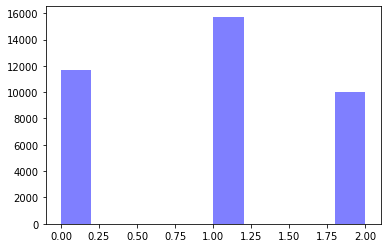

In [20]:
plt.hist(truths,color='b',range=(0.,2.),bins=10,alpha=0.5)
plt.show()

In [21]:
print(type(sys[0]))
print(len(sys[0]))

print(type(sys[0][0]))
print(len(sys[0][0]))

print(mult[0])
print(sys[0])
print(sys[0][0])

<class 'list'>
2
<class 'list'>
5
2.0
[[0.01078169415429975, 119.58818206705548, 5445.0, 4.455, 0.3], [0.0991979443274733, 283.4831481485871, 5445.0, 4.455, 0.3]]
[0.01078169415429975, 119.58818206705548, 5445.0, 4.455, 0.3]


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


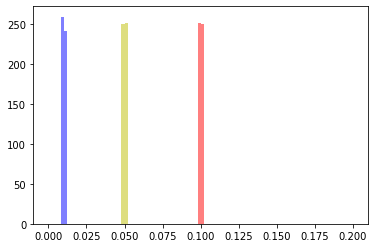

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


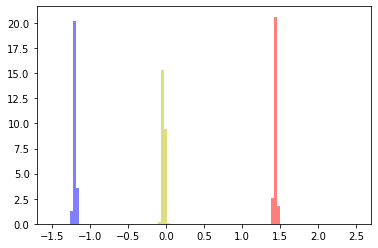

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


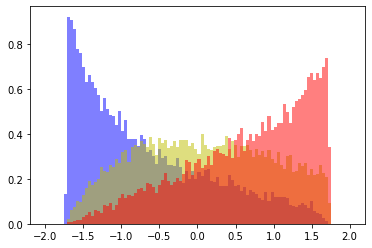

-1.725786072739461
1.7354828565654132
[]


In [22]:
plt.hist(np.array(rad[truths==0]),normed=True,range=(0,0.2),bins=100,color='b',alpha=0.5)
plt.hist(np.array(rad[truths==1]),normed=True,range=(0,0.2),bins=100,color='y',alpha=0.5)
plt.hist(np.array(rad[truths==2]),normed=True,range=(0,0.2),bins=100,color='r',alpha=0.5)
plt.show()

scaledRad = (rad - np.mean(rad))/np.std(rad)
plt.hist(np.array(scaledRad[truths==0]),normed=True,range=(-1.5,2.5),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledRad[truths==1]),normed=True,range=(-1.5,2.5),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledRad[truths==2]),normed=True,range=(-1.5,2.5),bins=100,color='r',alpha=0.5)
plt.show()


scaledPer = (pers - np.mean(pers))/np.std(pers)
plt.hist(np.array(scaledPer[truths==0]),normed=True,range=(-2.,2.),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledPer[truths==1]),normed=True,range=(-2.,2.),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledPer[truths==2]),normed=True,range=(-2.,2.),bins=100,color='r',alpha=0.5)
plt.show()

print(np.min(scaledPer))
print(np.max(scaledPer))
print(scaledPer[np.isnan(scaledPer)])

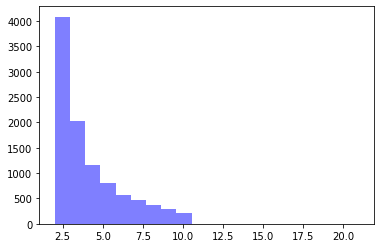

[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [23]:
plt.hist(mult,color='b',range=(2,21),bins=20,alpha=0.5)
plt.show()
print(np.unique(mult))

In [24]:
M = len(truths)
q0 = len(truths[truths==0])/M
q1 = len(truths[truths==1])/M
q2 = len(truths[truths==2])/M

print(q0)
print(q1)
print(q2)
print(q0+q1+q2)

entropy = q0*np.log(q0) +  q1*np.log(q1) +  q2*np.log(q2)

print(entropy)

0.3126502484107057
0.4202414658902719
0.2671082856990224
1.0
-1.080437232068239
